# Print Simple Tables
> Personal notes for different methods to print plain text tables in Python.

- toc: true
- badges: true
- comments: true
- categories: [general]

In [1]:
#hide

# PyPI
from bs4 import BeautifulSoup as BS
import requests

# Standard
import pprint
import json
import re

# SUPPORTING FUNCTIONS
def build_title(title: str) -> str:
    return f'-------------------------------\n{title}\n-------------------------------\n'

In [ ]:
#hide

import requests, json

query_url = 'https://idph.illinois.gov/DPHPublicInformation/api/COVID/GetResurgenceData?regionID=8&daysIncluded=3' #+ selectedRegion + '&daysIncluded=' + chartRange

page = requests.get(query_url)

print(build_title('CLI ADMISSIONS'))
pprint.pprint(page.json()['CLIAdmissions'])

print(build_title('COUNTRY TEST POSITIVITY REPORTS'))
pprint.pprint(page.json()['CountyTestPositivityReports'])

print(build_title('HOSPITAL AVAILABILITY'))
pprint.pprint(page.json()['HospitalAvailability'])

print(build_title('HOSPITAL BEDS IN USE AVG'))
pprint.pprint(page.json()['HospitalBedsInUseAvg'])

print(build_title('TEST POSITIVITY'))
pprint.pprint(page.json()['TestPositivity'])

print(build_title('LAST UPDATED DATE'))
pprint.pprint(page.json()['lastUpdatedDate'])

print(build_title('REGION METRICS'))
pprint.pprint(page.json()['regionMetrics'])

## Manually Created Tables

### Basic Table w/ Manual Column Size Control

- The sample data is Covid-19 region 8 information pulled from the Illinois Department of Public Health.
  - More data than is needed comes with this HTTP request.
  - Specific data used is for the County Test Positivity Reports.
- Code description:
    - **line 8:** printout of sample json object to show what the raw data looks like
    - **line 11:** Simplest form of creating a header: string printing of strings
    - **line 14:** The json object, 'countyTestPositivities', under 'CountryTestPositivityReports' contains a list of json objects inside - one for each county. The nested for loop takes the first object, loops through the nested list, then moves onto the next object and nested list.
    - **lines 16-26:** rudementry data clean up for the plain text table
      - This clean up involves both reformatting of data, but also ensuring that the cells in the table all line up.
      - Example - Data Formatting: "date" - `counties['reportDate'][:10]` takes the long datetime string and moves all of the time characters. It does this by cutting out any characters between the 10th character ([9]) in the string. There are better ways to do this using the datetime library, but this works as well.
      - Example - Table Formatting: "name"
        - We want the name column to always be 1 characters wide.
        - The first step is the basic action of setting the name variable from the pulled data
        - The second step is the following, in reverse order of the code in line 19:
          - (1) count (`len`) the number of characters in the name string
          - (2) subtract that number from the desired column width, which is 10 in this case (if the name is "Kane", then that would be 10 - 4 = 6)
          - (3) populate "name_fill" with a string of spaces the length of the result from the previous step (if the name is "Kane", then that would be a string of 6 spaces)
      - The column filler variable is setup for "name", "positive", "total", "daily_avg", and "seven_day_avg"
    - **line 27:** The content portion of the table is printed one line at a time using a combination of bars, spaces, and the pair of data variable and filler variable
    - **line 28:** Closes the bottm of the table with another string to match the header
- See the output further below for a visual of the raw data example, and the resulting plain text table

In [3]:
print(build_title('COUNTY TEST POSITIVITY REPORTS'))

query_url = 'https://idph.illinois.gov/DPHPublicInformation/api/COVID/GetResurgenceData?regionID=8&daysIncluded=5' #+ selectedRegion + '&daysIncluded=' + chartRange
page = requests.get(query_url)

positivity_rates = page.json()['CountyTestPositivityReports']
print('SINGLE SAMPLE')
pprint.pprint(positivity_rates[0])
print()

print('+-----------------------------------------------------------+')
print('| DATE       |  NAME      | POS    | TOTAL  | AVG   | 7 DAY |')
print('|-----------------------------------------------------------|')
for counties in positivity_rates:
    for i in counties['countyTestPositivities']:
        date = counties['reportDate'][:10]
        name = i['CountyName']
        name_fill = ' '*(10 - len(name))
        positive = i['positive_test']
        positive_fill = ' '*(6 - len(str(positive)))
        total = i['totalTest']
        total_fill = ' '*(6 - len(str(total)))
        daily_avg = round(float(i['positive_test']/i['totalTest']*100), 1) # positive tests / total tests * 100, then rounded to 1 decimal place
        daily_avg_fill = ' ' *(5 - len(str(daily_avg)))
        seven_day_avg = i['positivityRollingAvg']
        seven_fill = ' '*(5 - len(str(seven_day_avg)))
        print(f'| {date} | {name}{name_fill} | {positive}{positive_fill} | {total}{total_fill} | {daily_avg}{daily_avg_fill} | {seven_day_avg}{seven_fill} |')
print('+-----------------------------------------------------------+')

-------------------------------
COUNTY TEST POSITIVITY REPORTS
-------------------------------

SINGLE SAMPLE
{'countyTestPositivities': [{'CountyName': 'DuPage',
                             'dailyPositivity': 0.0,
                             'positive_test': 747,
                             'positivityRollingAvg': 13.5,
                             'regionID': 8,
                             'totalTest': 5344},
                            {'CountyName': 'Kane',
                             'dailyPositivity': 0.0,
                             'positive_test': 550,
                             'positivityRollingAvg': 16.4,
                             'regionID': 8,
                             'totalTest': 3792}],
 'reportDate': '2020-11-19T00:00:00'}

+-----------------------------------------------------------+
| DATE       |  NAME      | POS    | TOTAL  | AVG   | 7 DAY |
|-----------------------------------------------------------|
| 2020-11-19 | DuPage     | 747    | 5344   | 14

### Basic Table with Cleaned Up Data (and also w/ Manual Column Size Control)

In [4]:
import datetime
from datetime import date

# TABLE PARAMETERS
line_length = 59

print(build_title('COUNTY TEST POSITIVITY REPORTS'))

query_url = 'https://idph.illinois.gov/DPHPublicInformation/api/COVID/GetResurgenceData?regionID=8&daysIncluded=10' #+ selectedRegion + '&daysIncluded=' + chartRange
page = requests.get(query_url)

positivity_rates = page.json()['CountyTestPositivityReports']
print('SINGLE SAMPLE')
pprint.pprint(positivity_rates[-1])
behind = datetime.datetime.strptime(positivity_rates[-1]['reportDate'], "%Y-%m-%dT%H:%M:%S")
behind_str = f'CURRENT DATE: {date.today()} (Report is {(date.today() - behind.date()).days} days *behind*)'
behind_fill = ' '*(57 - len(behind_str))
print()
print(f'+{"="*line_length}+')
print(f'| {behind_str}{behind_fill} |')
print(f'|{"="*line_length}|')
print('| NAME       | DATE       | POS    | TOTAL  | AVG   | 7 DAY |')
print(f'|{"-"*line_length}|')
number_of_counties = len(positivity_rates[0]['countyTestPositivities'])
for n in range(number_of_counties):
    print_name = True
    for counties in positivity_rates:
        county = counties['countyTestPositivities'][n]#[n-1]
        date = counties['reportDate'][:10]
        name = county['CountyName'] if print_name == True else ''
        name_fill = ' '*(10 - len(name))
        positive = county['positive_test']
        positive_fill = ' '*(6 - len(str(positive)))
        total = county['totalTest']
        total_fill = ' '*(6 - len(str(total)))
        daily_avg = round(float(county['positive_test']/county['totalTest']*100), 1) # positive tests / total tests * 100, then rounded to 1 decimal place
        daily_avg_fill = ' ' *(5 - len(str(daily_avg)))
        seven_day_avg = county['positivityRollingAvg']
        seven_fill = ' '*(5 - len(str(seven_day_avg)))
        print(f'| {name}{name_fill} | {date} | {positive}{positive_fill} | {total}{total_fill} | {daily_avg}{daily_avg_fill} | {seven_day_avg}{seven_fill} |')
        print_name = False
    print(f'+{"-"*line_length}+')

-------------------------------
COUNTY TEST POSITIVITY REPORTS
-------------------------------

SINGLE SAMPLE
{'countyTestPositivities': [{'CountyName': 'DuPage',
                             'dailyPositivity': 0.0,
                             'positive_test': 777,
                             'positivityRollingAvg': 12.3,
                             'regionID': 8,
                             'totalTest': 6411},
                            {'CountyName': 'Kane',
                             'dailyPositivity': 0.0,
                             'positive_test': 517,
                             'positivityRollingAvg': 16.3,
                             'regionID': 8,
                             'totalTest': 3790}],
 'reportDate': '2020-11-24T00:00:00'}

+===========================================================+
| CURRENT DATE: 2020-11-28 (Report is 4 days *behind*)      |
|===========================================================|
| NAME       | DATE       | POS    | TOTAL  | AV

## Tables Created with **tabulate**

### Regular tabulate table

## Pandas tabulate table

- tablefmt options: `plain`, `simple`, `github`, `grid`, `fancy_grid`, `pipe`, `orgtbl`, `jira`, `fpresto`, `pretty`, `psql`, `rst`, `mediawiki`, `moinmoin`, `youtrack`, `html`, `latex`, `latex_raw`, `latex_booktabs`, `textile`

In [5]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import requests
import datetime

query_url = 'https://idph.illinois.gov/DPHPublicInformation/api/COVID/GetResurgenceData?regionID=8&daysIncluded=10' # max is 170 days #+ selectedRegion + '&daysIncluded=' + chartRange
page = requests.get(query_url)

positivity_rates = page.json()['CountyTestPositivityReports']

flattened_positivity_rates = []
for dates in positivity_rates:
    for county in dates['countyTestPositivities']:
        county['date'] = datetime.datetime.strptime(dates['reportDate'], "%Y-%m-%dT%H:%M:%S")
        flattened_positivity_rates.append(county)

county_test_pos_rates_df = pd.DataFrame(flattened_positivity_rates)
county_test_pos_rates_df['daily_avg'] = (county_test_pos_rates_df['positive_test'] / county_test_pos_rates_df['totalTest']) * 100

print(tabulate(county_test_pos_rates_df.sort_values(['CountyName', 'date']), headers = 'keys', tablefmt = 'psql'))

+----+--------------+-------------+-----------------+------------------------+-------------------+------------+---------------------+-------------+
|    | CountyName   |   totalTest |   positive_test |   positivityRollingAvg |   dailyPositivity |   regionID | date                |   daily_avg |
|----+--------------+-------------+-----------------+------------------------+-------------------+------------+---------------------+-------------|
|  0 | DuPage       |        4973 |             695 |                   14.6 |                 0 |          8 | 2020-11-14 00:00:00 |    13.9755  |
|  2 | DuPage       |        5628 |             699 |                   14.1 |                 0 |          8 | 2020-11-15 00:00:00 |    12.42    |
|  4 | DuPage       |        5619 |             756 |                   13.9 |                 0 |          8 | 2020-11-16 00:00:00 |    13.4544  |
|  6 | DuPage       |        5626 |             695 |                   13.5 |                 0 |          8 | 

#### Aside: Same Pandas Data Visualized

<AxesSubplot:xlabel='date'>

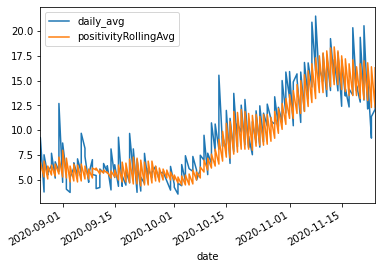

In [6]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pandas as pd
import requests

query_url = 'https://idph.illinois.gov/DPHPublicInformation/api/COVID/GetResurgenceData?regionID=8&daysIncluded=90' # max is 170 days #+ selectedRegion + '&daysIncluded=' + chartRange
page = requests.get(query_url)

positivity_rates = page.json()['CountyTestPositivityReports']

flattened_positivity_rates = []
for dates in positivity_rates:
    for county in dates['countyTestPositivities']:
        county['date'] = datetime.strptime(dates['reportDate'], "%Y-%m-%dT%H:%M:%S")
        flattened_positivity_rates.append(county)

county_test_pos_rates_df = pd.DataFrame(flattened_positivity_rates)
county_test_pos_rates_df['daily_avg'] = (county_test_pos_rates_df['positive_test'] / county_test_pos_rates_df['totalTest']) * 100

county_test_pos_rates_df.plot(y=['daily_avg', 'positivityRollingAvg'], x='date')

In [ ]:
#collapse-hide

# SAME GRAPH, BUT WITH INTERACTIVE ADJUSTMENTS

import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import requests

query_url = 'https://idph.illinois.gov/DPHPublicInformation/api/COVID/GetResurgenceData?regionID=8&daysIncluded=90' # max is 170 days #+ selectedRegion + '&daysIncluded=' + chartRange
page = requests.get(query_url)

positivity_rates = page.json()['CountyTestPositivityReports']

flattened_positivity_rates = []
for dates in positivity_rates:
    for county in dates['countyTestPositivities']:
        county['date'] = datetime.strptime(dates['reportDate'], "%Y-%m-%dT%H:%M:%S")
        flattened_positivity_rates.append(county)

county_test_pos_rates_df = pd.DataFrame(flattened_positivity_rates)
county_test_pos_rates_df['daily_avg'] = (county_test_pos_rates_df['positive_test'] / county_test_pos_rates_df['totalTest']) * 100

@interact(dpi=(100, 500), days=(30, 93, 7))
def graph(dpi=100, days=93):
    mpl.rcParams['figure.dpi'] = dpi
    number_prev_days = datetime.today() - timedelta (days)
    filtered_df=county_test_pos_rates_df.query(f"date <= '{datetime.today()}' and date >= '{number_prev_days}'")
    filtered_df.plot(y=['daily_avg', 'positivityRollingAvg'], x='date')